# Imports

In [1]:
from stltovoxel import slice
from stl import mesh

from PIL import Image
import tensorflow as tf

import numpy as np
from matplotlib import pyplot as plt
import random
from scipy import ndimage

# Load Input Files

In [2]:
input_file = 'stl/T1.1.stl'

# Function: Return 3D Data from STL file

In [3]:
def raw_stl_to_3d_array(input_file):
    meshes = []

    resolution = 200
    resize_val = (256, 256)

    parallel = False
    colors = [(255, 255, 255)]
    resolution -= 1

    mesh_obj = mesh.Mesh.from_file(input_file)
    org_mesh = np.hstack((mesh_obj.v0[:, np.newaxis], mesh_obj.v1[:, np.newaxis], mesh_obj.v2[:, np.newaxis]))
    meshes.append(org_mesh)

    scale, shift, shape = slice.calculate_scale_shift(meshes, resolution)
    voxels = np.zeros(shape[::-1], dtype=np.int8)

    for mesh_ind, org_mesh in enumerate(meshes):
        slice.scale_and_shift_mesh(org_mesh, scale, shift)
        vol = np.zeros(shape[::-1], dtype=bool)

        current_mesh_indices = set()
        z = 0
        for event_z, status, tri_ind in slice.generate_tri_events(org_mesh):
            while event_z - z >= 0:
                mesh_subset = [org_mesh[ind] for ind in current_mesh_indices]
                _, pixels = slice.paint_z_plane(mesh_subset, z, vol.shape[1:])
                vol[z] = pixels
                z += 1

            if status == 'start':
                assert tri_ind not in current_mesh_indices
                current_mesh_indices.add(tri_ind)
            elif status == 'end':
                assert tri_ind in current_mesh_indices
                current_mesh_indices.remove(tri_ind)

        voxels[vol] = mesh_ind + 1

    z_size = voxels.shape[0]

    size = str(len(str(z_size + 1)))

    # Black background
    colors = [(0, 0, 0)] + colors
    palette = [channel for color in colors for channel in color]

    data = []
    # Special case when white on black.
    for height in range(z_size):
        if colors == [(0, 0, 0), (255, 255, 255)]:
            img = Image.fromarray(voxels[height].astype('bool'))
        else:
            img = Image.fromarray(voxels[height].astype('uint8'), mode='P')
            img.putpalette(palette)

        data.append(np.array(img.resize(resize_val)).astype('int'))

    return np.array(data)

# Function: Rotate 3D array at given angle

In [4]:
@tf.function
def rotate(instance, angle):
    """Rotate the instance by a few degrees"""

    def scipy_rotate(instance):
        # rotate instance
        instance = ndimage.rotate(instance, angle, reshape=False)
        instance[instance < 0] = 0
        instance[instance > 1] = 1
        return instance

    augmented_instance = tf.numpy_function(scipy_rotate, [instance], tf.int32)
    return augmented_instance

# Function: Plot Slices from 3d numpy array

In [5]:
def plot_slices(num_rows, num_columns, width, height, data):
    data = np.reshape(data, (num_rows, num_columns, width, height))
    
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j])
            axarr[i, j].axis("off")
            
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

# Main Function

In [6]:
data = raw_stl_to_3d_array(input_file)

### Original File Plot

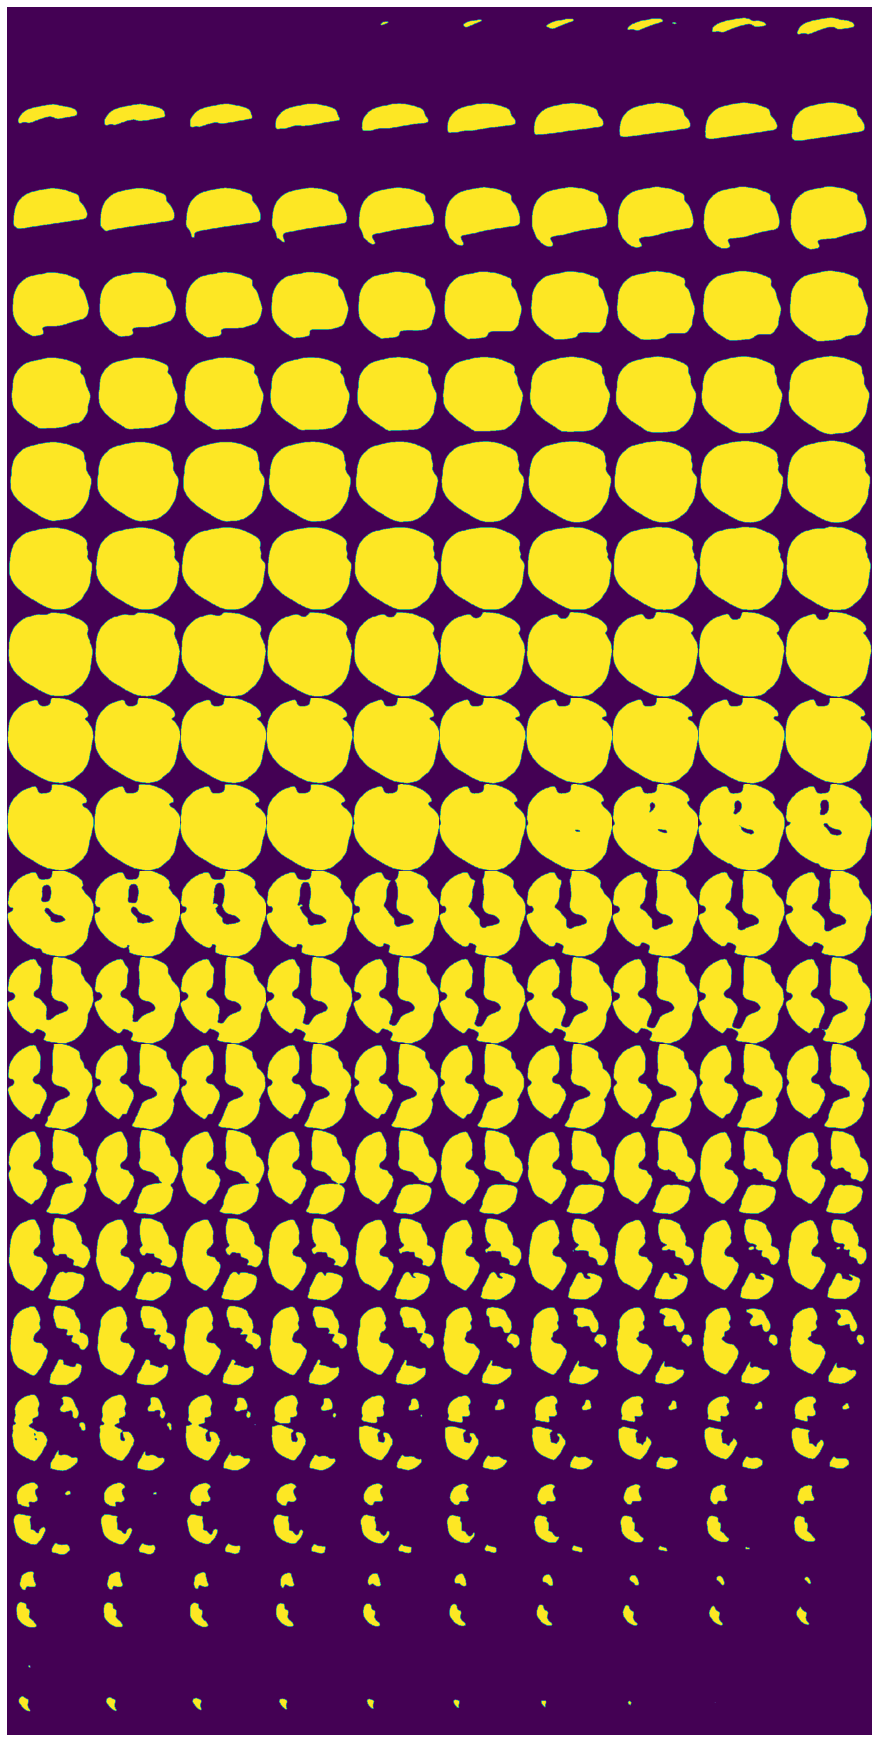

In [7]:
plot_slices(20, 10, 256, 256, data[:200, :, :])

### Random Angle Augmented Plot 1

Angle Rotated:  19


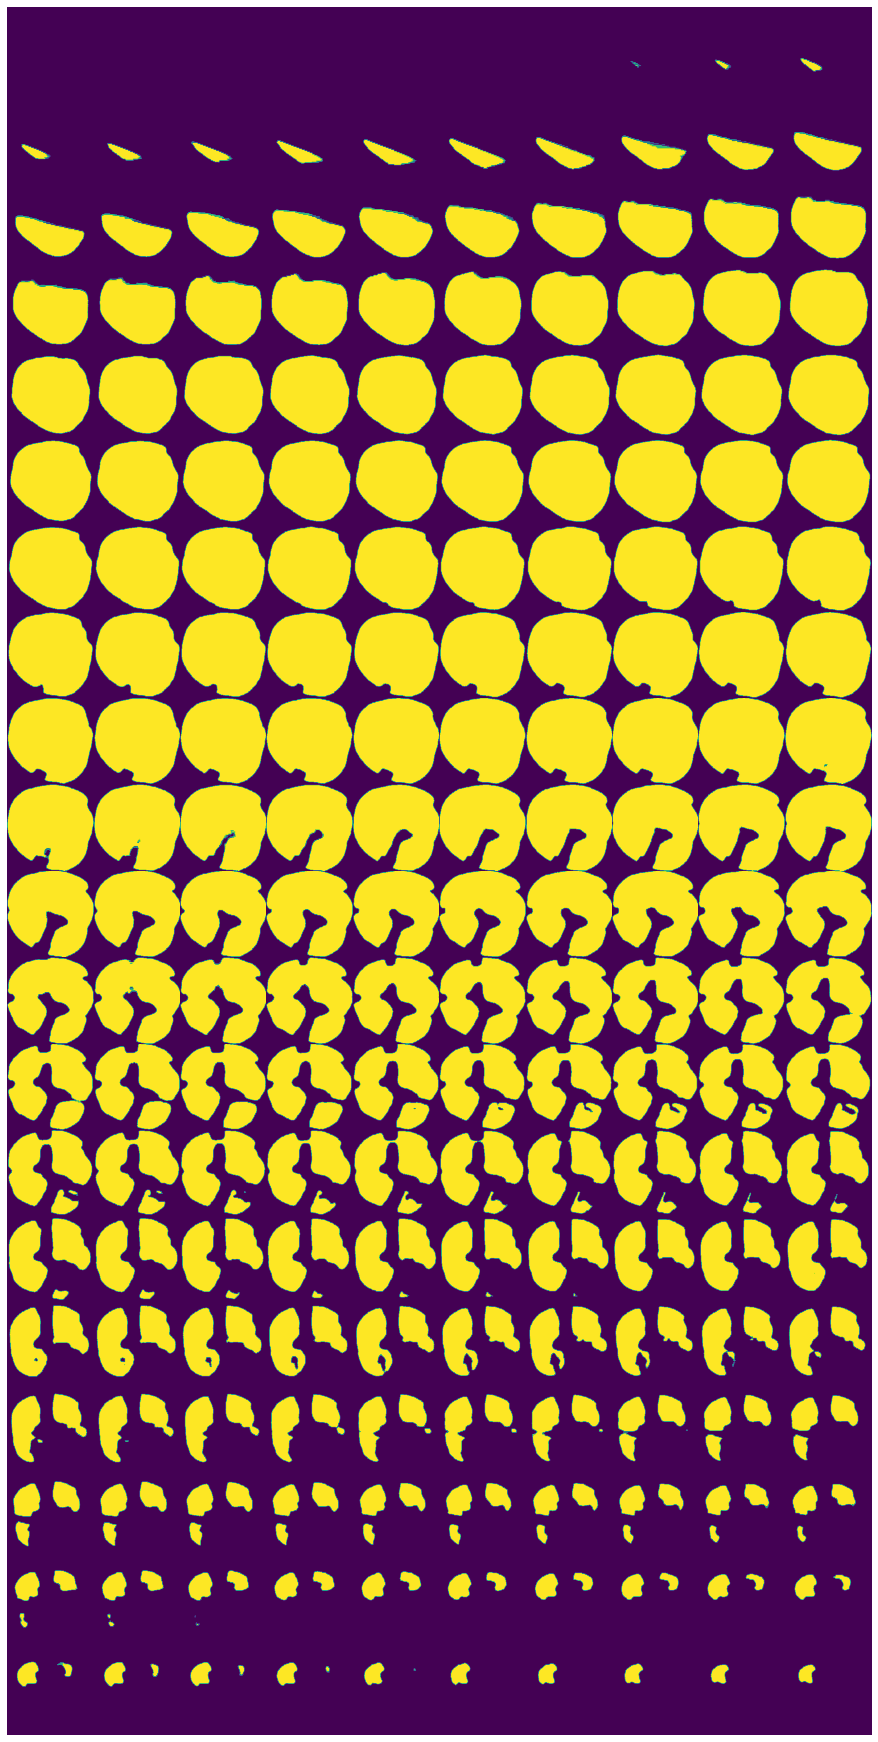

In [8]:
angle = random.randrange(-25, 25)
print('Angle Rotated: ', angle)

augment_1 = rotate(data, angle)
plot_slices(20, 10, 256, 256, augment_1[:200, :, :])

### Random Angle Augmented Plot 2

Angle Rotated:  -5


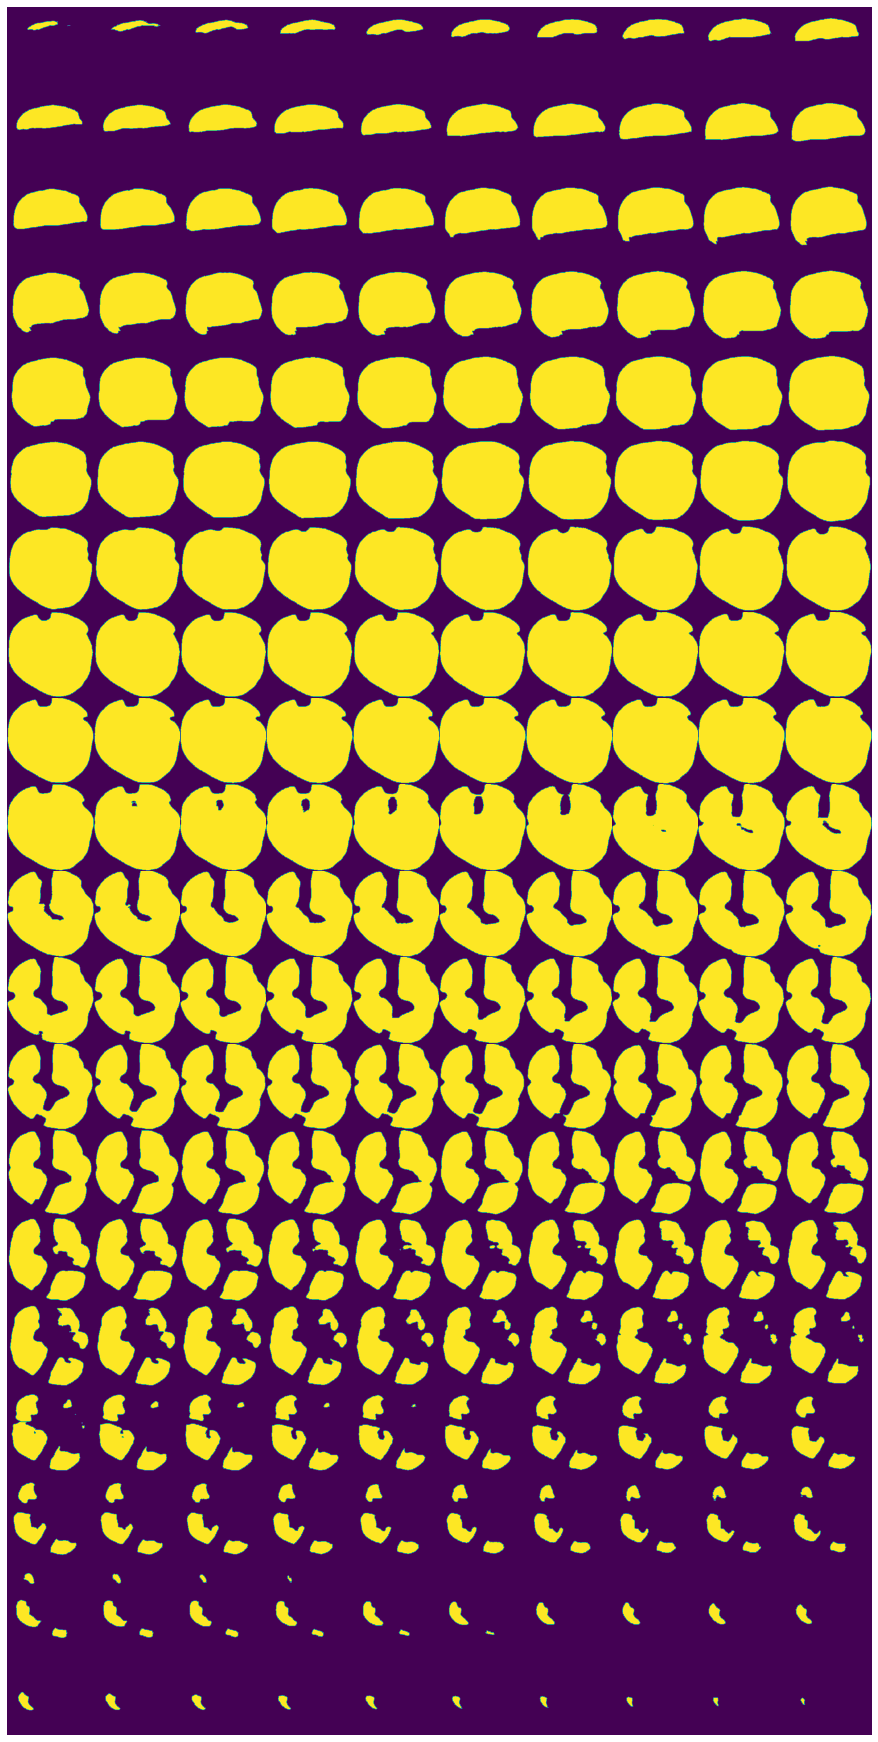

In [9]:
angle = random.randrange(-25, 25)
print('Angle Rotated: ', angle)

augment_2 = rotate(data, angle)
plot_slices(20, 10, 256, 256, augment_2[:200, :, :])